In [1]:
# 0) Install & imports
!pip install -q scikit-learn pandas numpy matplotlib nltk wordcloud ipywidgets

import os, io, re, ast, random, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils import resample

import nltk
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

random.seed(42)
np.random.seed(42)
print("✅ Imports ready")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0:00:00
✅ Imports ready


In [2]:
# 1) Load dataset
DATA_PATH = "/content/goodreads_data.csv"   # ensure you uploaded the CSV to Colab files
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Upload your dataset to {DATA_PATH} or change DATA_PATH.")

df = pd.read_csv(DATA_PATH)
print("✅ Loaded:", df.shape)
display(df.head())
print("\nMissing values:\n", df.isnull().sum())


✅ Loaded: (10000, 8)


,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...



Missing values:
 Unnamed: 0      0
Book            0
Author          0
Description    77
Genres          0
Avg_Rating      0
Num_Ratings     0
URL             0
dtype: int64


In [3]:
# 2) Extract first genre (Primary) and create a simplified label mapping
def extract_first_genre(x):
    if pd.isna(x):
        return "Unknown"
    try:
        if isinstance(x, str) and x.strip().startswith('['):
            genres = ast.literal_eval(x)
            if isinstance(genres, (list,tuple)) and len(genres)>0:
                return str(genres[0]).strip()
        parts = re.split(r"[;,/|]", str(x))
        if len(parts)>0:
            return parts[0].strip().strip("[]'\" ")
    except Exception:
        pass
    return str(x).strip()

df['primary_genre'] = df['Genres'].apply(extract_first_genre)
df['Description'] = df['Description'].fillna("").astype(str)

# Quick counts
print("Top primary genres:")
print(df['primary_genre'].value_counts().head(20))


Top primary genres:
primary_genre
Fiction               1711
                       960
Nonfiction             957
Fantasy                942
Classics               515
Historical Fiction     467
Mystery                387
Young Adult            386
Science Fiction        325
Romance                298
History                197
Horror                 192
Thriller               180
Self Help              154
Poetry                 146
Philosophy             140
Business               112
Plays                  106
Childrens               92
Picture Books           89
Name: count, dtype: int64


In [4]:
# 3) Simplify genres using keyword mapping to get stable classes
def simplify_genre(g):
    s = str(g).lower()
    if 'fiction' in s and 'non' not in s:
        return 'Fiction'
    if 'nonfiction' in s or 'non-fiction' in s or 'non fiction' in s or 'biograph' in s or 'memoir' in s:
        return 'Non-Fiction'
    if 'fantasy' in s:
        return 'Fantasy'
    if 'romance' in s:
        return 'Romance'
    if 'mystery' in s or 'thriller' in s or 'crime' in s:
        return 'Mystery'
    if 'science fiction' in s or 'sci-fi' in s or 'scifi' in s:
        return 'Science Fiction'
    if 'classic' in s or 'classics' in s or 'austen' in s or 'dickens' in s:
        return 'Classics'
    if 'history' in s:
        return 'History'
    return 'Other'

df['genre_reduced'] = df['primary_genre'].apply(simplify_genre)
print("Counts after simplify:")
print(df['genre_reduced'].value_counts())


Counts after simplify:
genre_reduced
Other          3746
Fiction        2539
Non-Fiction    1069
Fantasy         974
Mystery         604
Classics        515
Romance         355
History         198
Name: count, dtype: int64


In [5]:
# 4) Keep genres with at least min_count examples (so model can learn). drop 'Other' optionally.
min_count = 60   # tune: 60 is a sensible default; increase for stricter filtering
counts = df['genre_reduced'].value_counts()
valid_genres = counts[counts >= min_count].index.tolist()
print("Genres with >=%d examples:" % min_count, valid_genres)

# Filter dataset to only valid genres
df_filtered = df[df['genre_reduced'].isin(valid_genres)].reset_index(drop=True)
print("After filtering:", df_filtered.shape)
print(df_filtered['genre_reduced'].value_counts())


Genres with >=60 examples: ['Other', 'Fiction', 'Non-Fiction', 'Fantasy', 'Mystery', 'Classics', 'Romance', 'History']
After filtering: (10000, 10)
genre_reduced
Other          3746
Fiction        2539
Non-Fiction    1069
Fantasy         974
Mystery         604
Classics        515
Romance         355
History         198
Name: count, dtype: int64


In [6]:
# 5) Text cleaning
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    toks = [w for w in text.split() if w not in stop_words and len(w)>1]
    toks = [lemmatizer.lemmatize(t) for t in toks]
    return " ".join(toks)

print("Cleaning text (this may take a few seconds)...")
df_filtered['clean_desc'] = df_filtered['Description'].apply(clean_text)
display(df_filtered[['Book','primary_genre','genre_reduced','clean_desc']].head())


Cleaning text (this may take a few seconds)...


,Book,primary_genre,genre_reduced,clean_desc
0,To Kill a Mockingbird,Classics,Classics,unforgettable novel childhood sleepy southern ...
1,Harry Potter and the Philosopher’s Stone (Harr...,Fantasy,Fantasy,harry potter think ordinary boy rescued owl ta...
2,Pride and Prejudice,Classics,Classics,since immediate success 1813 pride prejudice r...
3,The Diary of a Young Girl,Classics,Classics,discovered attic spent last year life anne fra...
4,Animal Farm,Classics,Classics,librarian note alternate cover edition edition...


In [7]:
# 6) Encode labels and split
le = LabelEncoder()
df_filtered['label_encoded'] = le.fit_transform(df_filtered['genre_reduced'])
print("Classes:", list(le.classes_))

X = df_filtered['clean_desc'].values
y = df_filtered['label_encoded'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train / Test sizes:", len(X_train), len(X_test))


Classes: ['Classics', 'Fantasy', 'Fiction', 'History', 'Mystery', 'Non-Fiction', 'Other', 'Romance']
Train / Test sizes: 8000 2000


In [8]:
# 7) TF-IDF
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (8000, 20000) (2000, 20000)


In [9]:
# 8) Optional: balance classes by downsampling majority classes (uncomment to use)
# NOTE: balancing may help for very skewed datasets. If you prefer class weights instead, skip this cell.

do_balance = False  # set True to run balancing then retrain from next cell
if do_balance:
    df_train = pd.DataFrame({'text': X_train, 'label': y_train})
    balanced = []
    max_per_class = min(df_train['label'].value_counts().max(), 1000)  # cap
    for lab, sub in df_train.groupby('label'):
        if len(sub) > max_per_class:
            sub = sub.sample(max_per_class, random_state=42)
        balanced.append(sub)
    df_bal = pd.concat(balanced).sample(frac=1, random_state=42)
    X_train = df_bal['text'].values
    y_train = df_bal['label'].values
    X_train_tfidf = tfidf.fit_transform(X_train)
    print("Balanced training shape:", X_train_tfidf.shape)
else:
    print("Balancing skipped (do_balance=False)")


Balancing skipped (do_balance=False)


In [10]:
# 9) Train models (MultinomialNB, LogisticRegression with class_weight, RandomForest with class_weight)
models = {
    'NaiveBayes': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1200, class_weight='balanced', n_jobs=-1),
    'RandomForest': RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1)
}

trained_models = {}
metrics_summary = {}

for name, mdl in models.items():
    print("Training", name)
    mdl.fit(X_train_tfidf, y_train)
    trained_models[name] = mdl
    preds = mdl.predict(X_test_tfidf)
    metrics_summary[name] = {
        'accuracy': accuracy_score(y_test, preds),
        'f1_weighted': f1_score(y_test, preds, average='weighted', zero_division=0),
        'precision_weighted': precision_score(y_test, preds, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_test, preds, average='weighted', zero_division=0)
    }
    print(f" -> acc {metrics_summary[name]['accuracy']:.4f}, f1 {metrics_summary[name]['f1_weighted']:.4f}")

metrics_df = pd.DataFrame(metrics_summary).T.sort_values(by='f1_weighted', ascending=False)
display(metrics_df)


Training NaiveBayes
 -> acc 0.4820, f1 0.3733
Training LogisticRegression
 -> acc 0.5900, f1 0.5902
Training RandomForest
 -> acc 0.5290, f1 0.4714


,accuracy,f1_weighted,precision_weighted,recall_weighted
LogisticRegression,0.590,0.590169,0.619180,0.590
RandomForest,0.529,0.471361,0.607031,0.529
NaiveBayes,0.482,0.373279,0.452075,0.482


Saved artifacts to ./artifacts/
Best model: LogisticRegression

Classification report (best model):

              precision    recall  f1-score   support

    Classics       0.44      0.59      0.51       103
     Fantasy       0.58      0.75      0.66       195
     Fiction       0.69      0.63      0.66       508
     History       0.37      0.54      0.44        39
     Mystery       0.54      0.82      0.65       121
 Non-Fiction       0.50      0.63      0.55       214
       Other       0.69      0.47      0.56       749
     Romance       0.38      0.68      0.48        71

    accuracy                           0.59      2000
   macro avg       0.52      0.64      0.56      2000
weighted avg       0.62      0.59      0.59      2000



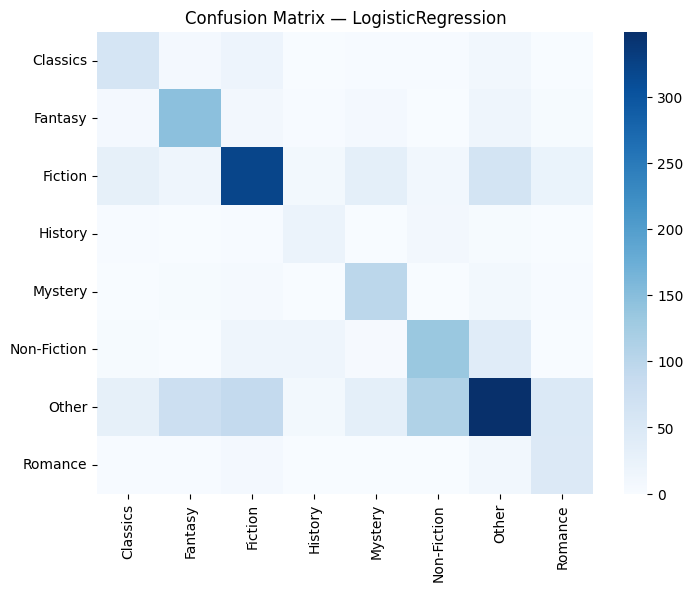

In [11]:
# 10) Save artifacts and show detailed eval of best model
os.makedirs('artifacts', exist_ok=True)
for name, mdl in trained_models.items():
    joblib.dump(mdl, f'artifacts/{name}.joblib')
joblib.dump(tfidf, 'artifacts/tfidf_vectorizer.joblib')
joblib.dump(le, 'artifacts/label_encoder.joblib')
print("Saved artifacts to ./artifacts/")

best = metrics_df['f1_weighted'].idxmax()
print("Best model:", best)
best_mdl = trained_models[best]
preds = best_mdl.predict(X_test_tfidf)
print("\nClassification report (best model):\n")
print(classification_report(y_test, preds, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title(f"Confusion Matrix — {best}")
plt.show()


Word clouds for retained genres:


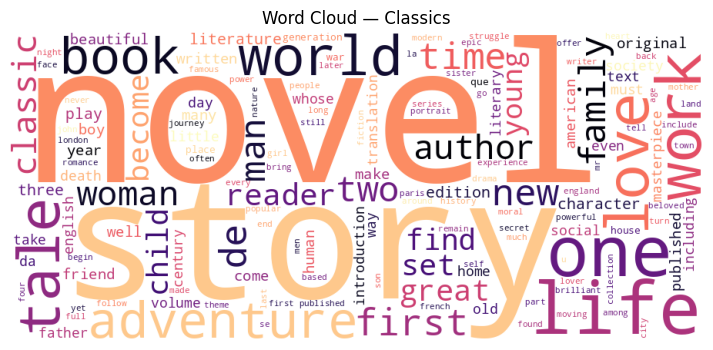

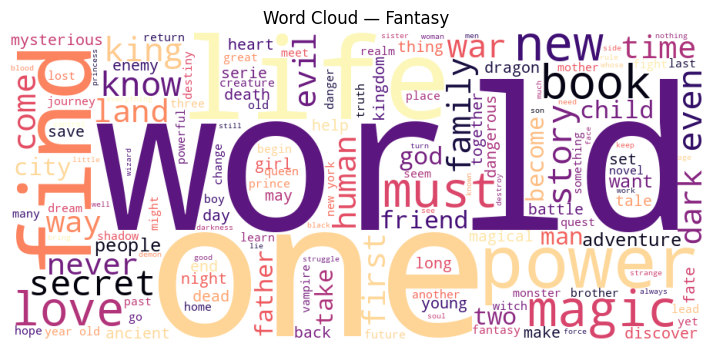

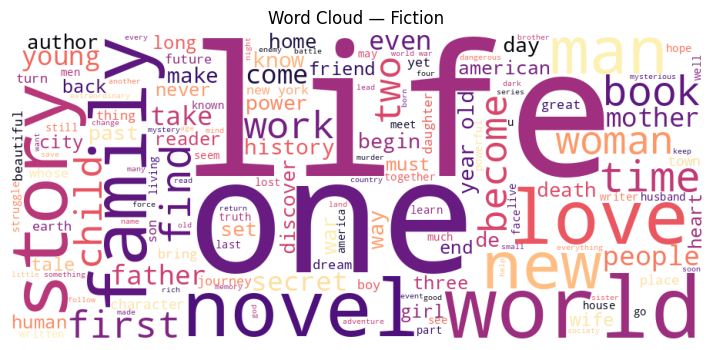

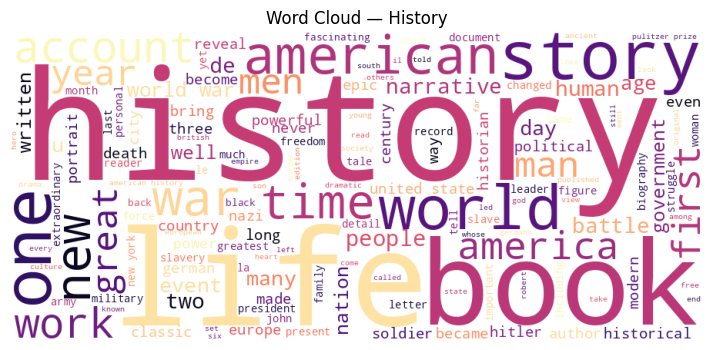

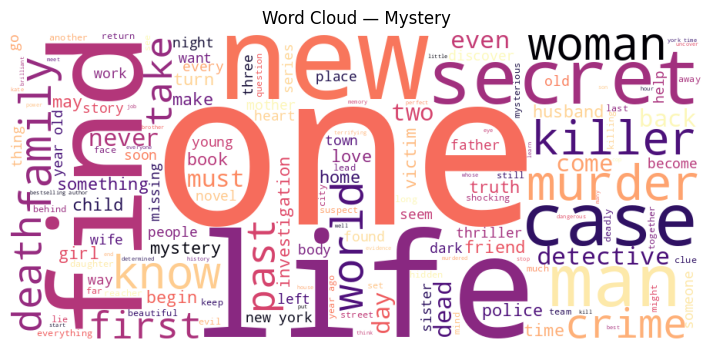

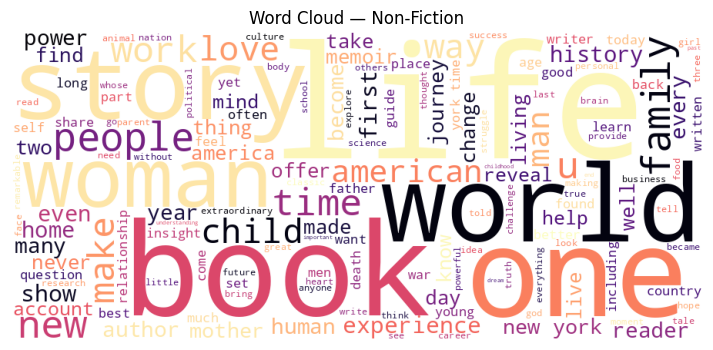

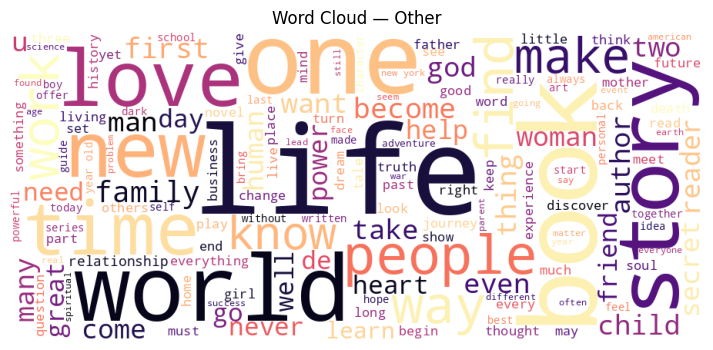

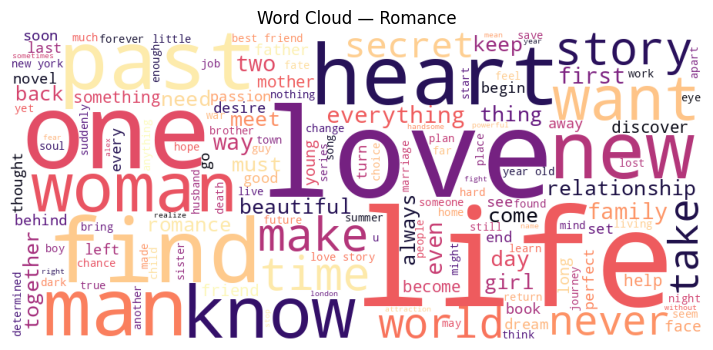

In [12]:
# 11) Word clouds for each retained genre
print("Word clouds for retained genres:")
for g in sorted(df_filtered['genre_reduced'].unique()):
    texts = df_filtered[df_filtered['genre_reduced']==g]['clean_desc'].tolist()
    text_joined = " ".join(texts)
    if not text_joined.strip():
        continue
    wc = WordCloud(width=900, height=400, background_color='white', max_words=150, colormap='magma').generate(text_joined)
    plt.figure(figsize=(12,4)); plt.imshow(wc); plt.axis('off'); plt.title(f"Word Cloud — {g}"); plt.show()


In [14]:
# 12) Interactive Dashboard (styled) — choose model, choose sample, predict, show top probs & similar books
from sklearn.metrics.pairwise import cosine_similarity

# Load artifacts (ensure the variables exist; if you re-run whole notebook they will)
tfidf = joblib.load('artifacts/tfidf_vectorizer.joblib')
le = joblib.load('artifacts/label_encoder.joblib')
trained_models = {name: joblib.load(f'artifacts/{name}.joblib') for name in models.keys()}

display(HTML("<h2 style='color:purple;text-align:center;'>📚 Book Genre Classification Dashboard</h2>"))

model_dropdown = widgets.Dropdown(options=list(trained_models.keys()), description='Model:', value=list(trained_models.keys())[0])
sample_dropdown = widgets.Dropdown(options=['-- choose sample --'] + df_filtered.index[:200].astype(str).tolist(), description='Sample:')
upload_btn = widgets.FileUpload(accept='.csv', multiple=False, description='📂 Upload Test CSV')
desc_input = widgets.Textarea(placeholder='Paste a book description...', layout=widgets.Layout(width='100%', height='140px'))
predict_button = widgets.Button(description='🔮 Predict Genre', button_style='info', layout=widgets.Layout(width='30%'))
output_box = widgets.Output(layout={'border': '1px solid #555', 'padding':'10px', 'background':'#111', 'color':'white'})

def on_sample_change(change):
    if change['new'] and change['new'] != '-- choose sample --':
        idx = int(change['new'])
        desc_input.value = df_filtered.loc[idx, 'Description']

sample_dropdown.observe(on_sample_change, names='value')

uploaded_test_df = None
def on_upload_change(change):
    global uploaded_test_df
    if upload_btn.value:
        uploaded_file = list(upload_btn.value.values())[0]
        uploaded_test_df = pd.read_csv(io.BytesIO(uploaded_file['content']))
        with output_box:
            clear_output()
            print("Uploaded test shape:", uploaded_test_df.shape)
            display(uploaded_test_df.head())

upload_btn.observe(on_upload_change, names='value')

def on_predict_clicked(b):
    with output_box:
        clear_output()
        model_name = model_dropdown.value
        text = desc_input.value.strip()
        if not text:
            print("⚠️ Enter a text or choose a sample.")
            return
        # predict
        model = trained_models[model_name]
        vec = tfidf.transform([clean_text(text)])
        pred_enc = model.predict(vec)[0]
        pred_label = le.inverse_transform([pred_enc])[0]
        print(f"🎯 Predicted Genre: {pred_label}   (Model: {model_name})\n")
        # top probs
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(vec)[0]
            top_idx = np.argsort(probs)[::-1][:5]
            print("📊 Top probabilities:")
            for i in top_idx:
                lab = le.inverse_transform([i])[0]
                print(f"  {lab:<18} {probs[i]:.2%}")
            print("")
        # similar books
        sample_idx = np.random.choice(range(X_train_tfidf.shape[0]), size=min(1200, X_train_tfidf.shape[0]), replace=False)
        sims = cosine_similarity(vec, X_train_tfidf[sample_idx]).flatten()
        topk = np.argsort(sims)[::-1][:5]
        print("📚 Similar books (training set):")
        for k in topk:
            idx = sample_idx[k]
            snippet = X_train[idx][:220]
            title = df_filtered.iloc[idx]['Book'] if 'Book' in df_filtered.columns else f"idx:{idx}"
            genre_of = df_filtered.iloc[idx]['genre_reduced'] if 'genre_reduced' in df_filtered.columns else "NA"
            print(f" • {title} — {genre_of}")
        # batch predict if uploaded
        if uploaded_test_df is not None:
            possible = [c for c in uploaded_test_df.columns if 'desc' in c.lower() or 'text' in c.lower()]
            if possible:
                col = possible[0]
                texts = uploaded_test_df[col].astype(str).tolist()[:10]
                Xv = tfidf.transform([clean_text(t) for t in texts])
                preds = model.predict(Xv)
                labs = le.inverse_transform(preds)
                print("\n📦 Batch predictions (first 10):")
                for i,(t,l) in enumerate(zip(texts,labs),1):
                    print(f"{i}. {l} | {t[:120]}...")
            else:
                print("⚠️ Uploaded CSV has no description/text column.")

predict_button.on_click(on_predict_clicked)

display(widgets.VBox([widgets.HBox([model_dropdown, sample_dropdown, upload_btn]),
                      widgets.HTML("<p style='color:gray;'>Enter a book description below and click <b>Predict Genre</b>:</p>"),
                      desc_input, widgets.HBox([predict_button], layout=widgets.Layout(justify_content='center')), output_box]))


🎯 Predicted Genre: Other   (Model: NaiveBayes)

📊 Top probabilities:
  Other              47.30%
  Fiction            37.48%
  Classics           5.92%
  Non-Fiction        4.24%
  Fantasy            3.34%

📚 Similar books (training set):
 • The Advantage: Why Organizational Health Trumps Everything Else In Business — Other
 • Spilled Coffee — Fiction
 • All Creatures Great and Small (All Creatures Great and Small, #1-2) — Non-Fiction
 • The Fog — Other
 • Hot Water Music — Fiction


In [17]:
# 12) Interactive Dashboard (fixed version)
from sklearn.metrics.pairwise import cosine_similarity

# reload artifacts (safe)
tfidf = joblib.load('artifacts/tfidf_vectorizer.joblib')
le = joblib.load('artifacts/label_encoder.joblib')
trained_models = {name: joblib.load(f'artifacts/{name}.joblib') for name in models.keys()}

display(HTML("<h2 style='color:purple;text-align:center;'>📚 Book Genre Classification Dashboard</h2>"))

# widgets
model_dropdown = widgets.Dropdown(options=list(trained_models.keys()), description='Model:', value=list(trained_models.keys())[0])
sample_dropdown = widgets.Dropdown(options=['-- choose sample --'] + df_filtered.index[:200].astype(str).tolist(), description='Sample:')
upload_btn = widgets.FileUpload(accept='.csv', multiple=False, description='📂 Upload Test CSV')
desc_input = widgets.Textarea(placeholder='Paste a book description...', layout=widgets.Layout(width='100%', height='140px'))
predict_button = widgets.Button(description='🔮 Predict Genre', button_style='info', layout=widgets.Layout(width='30%'))
output_box = widgets.Output(layout={'border': '1px solid #555', 'padding':'10px', 'background':'#111', 'color':'white', 'max_height':'300px', 'overflow_y':'auto'})

# fill description when selecting a sample
def on_sample_change(change):
    if change['new'] and change['new'] != '-- choose sample --':
        idx = int(change['new'])
        desc_input.value = df_filtered.loc[idx, 'Description']

sample_dropdown.observe(on_sample_change, names='value')

# handle upload
uploaded_test_df = None
def on_upload_change(change):
    global uploaded_test_df
    if upload_btn.value:
        uploaded_file = list(upload_btn.value.values())[0]
        uploaded_test_df = pd.read_csv(io.BytesIO(uploaded_file['content']))
        with output_box:
            print("✅ Uploaded test file:", uploaded_file['metadata']['name'])
            print("Shape:", uploaded_test_df.shape)
            display(uploaded_test_df.head(3))

upload_btn.observe(on_upload_change, names='value')

# predict handler
def on_predict_clicked(b):
    output_box.clear_output(wait=True)   # ✅ only clear results, not the whole dashboard
    with output_box:
        model_name = model_dropdown.value
        text = desc_input.value.strip()
        if not text:
            print("⚠️ Please enter or choose a book description.")
            return
        model = trained_models[model_name]
        vec = tfidf.transform([clean_text(text)])
        pred_enc = model.predict(vec)[0]
        pred_label = le.inverse_transform([pred_enc])[0]
        print(f"🎯 Predicted Genre: {pred_label}   (Model: {model_name})\n")

        # top probabilities
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(vec)[0]
            top_idx = np.argsort(probs)[::-1][:5]
            print("📊 Top genre probabilities:")
            for i in top_idx:
                lab = le.inverse_transform([i])[0]
                print(f"  {lab:<18} {probs[i]:.2%}")
            print("")

        # show similar books
        sample_idx = np.random.choice(range(X_train_tfidf.shape[0]), size=min(1200, X_train_tfidf.shape[0]), replace=False)
        sims = cosine_similarity(vec, X_train_tfidf[sample_idx]).flatten()
        topk = np.argsort(sims)[::-1][:5]
        print("📚 Similar books (from training set):")
        for k in topk:
            idx = sample_idx[k]
            title = df_filtered.iloc[idx]['Book'] if 'Book' in df_filtered.columns else f"Index {idx}"
            genre_of = df_filtered.iloc[idx]['genre_reduced'] if 'genre_reduced' in df_filtered.columns else "NA"
            print(f" • {title} — {genre_of}")

        # batch predictions if uploaded
        if uploaded_test_df is not None:
            print("\n📦 Batch predictions (first 10):")
            possible = [c for c in uploaded_test_df.columns if 'desc' in c.lower() or 'text' in c.lower()]
            if possible:
                col = possible[0]
                texts = uploaded_test_df[col].astype(str).tolist()[:10]
                Xv = tfidf.transform([clean_text(t) for t in texts])
                preds = model.predict(Xv)
                labs = le.inverse_transform(preds)
                for i,(t,l) in enumerate(zip(texts,labs),1):
                    print(f"{i}. {l} | {t[:120]}...")
            else:
                print("⚠️ No description/text column found in uploaded CSV.")

predict_button.on_click(on_predict_clicked)

# layout
ui = widgets.VBox([
    widgets.HBox([model_dropdown, sample_dropdown, upload_btn]),
    widgets.HTML("<p style='color:gray;'>Enter a book description below and click <b>Predict Genre</b>:</p>"),
    desc_input,
    widgets.HBox([predict_button], layout=widgets.Layout(justify_content='center')),
    output_box
])
display(ui)
